## Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
from tkinter import filedialog
from tkinter import *
from roipoly import RoiPoly
from scipy.stats import mode
import cv2
from bpass import bpass
from imshift import imshift
import openpiv.tools as tools
import openpiv.process
import openpiv.scaling
import openpiv.validation
import openpiv.filters

C:\Users\htmtri\AppData\Local\Continuum\miniconda3\lib\site-packages\pywt\_utils.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


## Load imgs

Get images needed for TFM experiment using UI from tkinter:
Skip this and go directly to LOAD PROCESSED IMGS cell if you had already pre-process all images (including image crop, cell trace, bpass filter and dedrift).

In [3]:
root = Tk()

#root.directory = filedialog.askdirectory()

root.pc_name = filedialog.askopenfilename(initialdir = '.',
                                          title = "Select phase contrast img",
                                          filetypes = (("tiff files","*.tiff"),
                                          ("all files","*.*")))

root.load_name = filedialog.askopenfilename(initialdir = '.',
                                     title = "Select loadimg",
                                     filetypes = (("tiff files","*.tiff"),
                                                  ("all files","*.*")))
root.nulf_name = filedialog.askopenfilename(initialdir = '.',
                                     title = "Select nulfimg",
                                     filetypes = (("tiff files","*.tiff"),("all files","*.*")))


frame_c = plt.imread(root.pc_name)
org_b = plt.imread(root.nulf_name)
org_a = plt.imread(root.load_name)

root.withdraw()

''

Showing all input images:

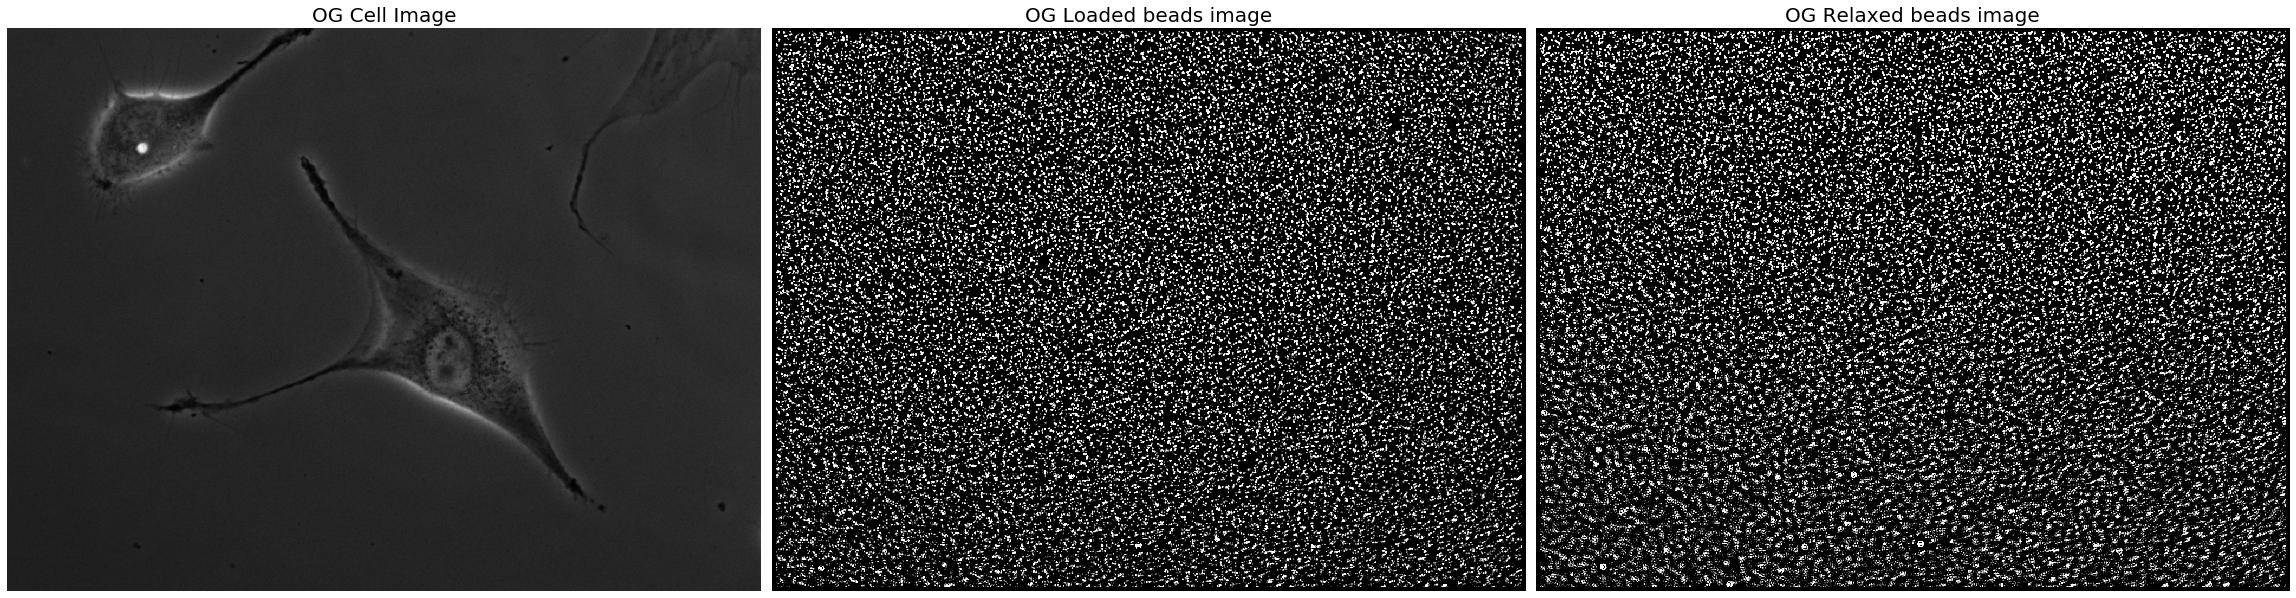

In [42]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(32,20),sharex=True,sharey=True)

ax[0].imshow(frame_c,CMAP='gray',origin='lower')
ax[0].axis('off')
ax[0].set_title('OG Cell Image',fontsize=20)

ax[1].imshow(frame_a,CMAP='gray',origin='lower',vmin=0,vmax=0.01*org_a.max())
ax[1].axis('off')
ax[1].set_title('OG Loaded beads image',fontsize=20)

ax[2].imshow(frame_b,CMAP='gray',origin='lower',vmin=0,vmax=0.01*org_b.max())
ax[2].axis('off')
ax[2].set_title('OG Relaxed beads image',fontsize=20)

fig.tight_layout()
plt.show(block=False)

## Crop ROI

Identify region of interest (cell of interest). First, select the rectangle eclosing the cell (drag from top left to bottom right, press ESC to finish). Next, select the region without any cells for dedrifting, noise purpose.

In [5]:
c_uint8 = cv2.convertScaleAbs(frame_c,alpha=0.5)

showCrosshair = False
fromCenter = False

#drag from top left to bot right .press ESC to finish
rect = cv2.selectROI('Cell ROI',c_uint8,fromCenter, showCrosshair) 
recs = cv2.selectROI('Empty ROI',c_uint8,fromCenter, showCrosshair)

## bpass filter and stage drift

Applying bandpass to clean up beads images. Change noise kernel, feature size and threshold as you need. Next, we will determine the shift between loaded and relaxed images by doing cross-correlation on the empty region without cells.

In [6]:
frame_b = bpass(org_b,lnoise=0,lobject=7,threshold=0.05*mode(org_b.flatten())[0])
frame_a = bpass(org_a,lnoise=0,lobject=7,threshold=0.05*mode(org_a.flatten())[0])
drift = imshift(frame_a,frame_b,recs)

Crop all frames using ROI defined above and dedrift the relaxed image base on cross-correlation result:

In [7]:
cellimg = frame_c[int(rect[1]):int(rect[1]+rect[3]), int(rect[0]):int(rect[0]+rect[2])]
loadimg = frame_a[int(rect[1]):int(rect[1]+rect[3]), int(rect[0]):int(rect[0]+rect[2])]
nulfimg = frame_b[int(rect[1]+drift[1]):int(rect[1]+rect[3]+drift[1]), int(rect[0]+drift[0]):int(rect[0]+rect[2]+drift[0])]

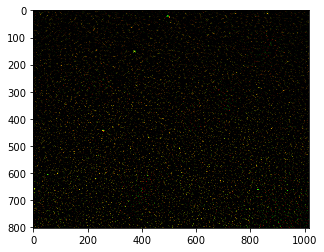

In [37]:
%matplotlib inline
cimg = np.zeros([cellimg.shape[0],cellimg.shape[1],3],dtype=np.uint8)
cimg[:,:,0] = loadimg
cimg[:,:,1] = nulfimg
plt.figure()
plt.imshow(cimg,vmin=0,vmax=cimg[:,:,0].max())

## Cell Boundary Trace

Trace the cell boundary. Left click to register points on image, right click or double click to close cell region.

In [12]:
%matplotlib qt
fig = plt.figure()
plt.imshow(cellimg,cmap='gray',vmin=0,vmax=0.5*cellimg.max())
plt.title("left click: line segment; right click or double click: close region")
plt.show(block=False)

cell_roi = RoiPoly(color='r',fig=fig,show_fig=False)

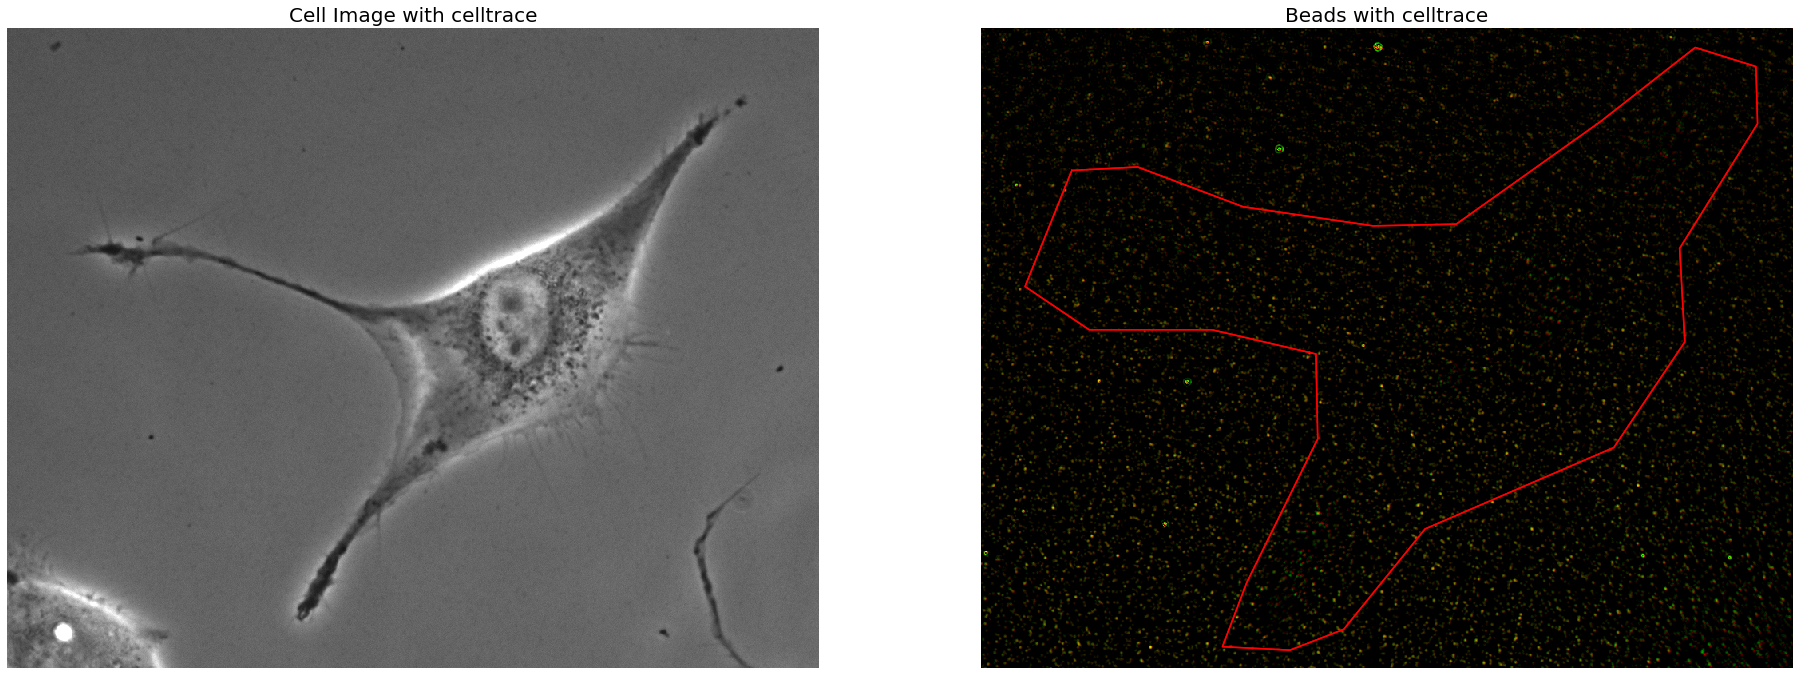

In [40]:
%matplotlib inline

#plt.figure()
#plt.plot(cell_roi.x,cell_roi.y,color='r',linewidth=2.5)
#plt.plot(cell_roi.x + [cell_roi.x[0]],cell_roi.y + [cell_roi.y[0]],color='b')
#plt.show(block=False)
#cell_roi does not close boundary itself
cellx = np.array(cell_roi.x + [cell_roi.x[0]])
celly = np.array(cell_roi.y + [cell_roi.y[0]])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(32,20),sharex=True,sharey=True)
ax[0].imshow(cellimg,cmap='gray',vmin=0,vmax=0.5*cellimg.max())
cell_roi.display_roi()
ax[0].axis('off')
ax[0].set_title('Cell Image with celltrace',fontsize=20)

ax[1].imshow(cimg,cmap='gray',vmin=0,vmax=0.5*cellimg.max())
ax[1].plot(cellx,celly,color='r')
ax[1].axis('off')
ax[1].set_title('Beads with celltrace',fontsize=20)
plt.show(block=False)

## Loading processed imgs (start here if you had the preprocessed the imgs)

If you have the processed images, start here. Input format is '.npz'. You need to have these fields in the file: 
 - 'cellTrace': nx2 array storing vertices of the cell boundary
 - cellimg: cropped phase(bright) field image of the cell
 - loadimg: cropped and filtered load bead image
 - nulfimg: cropped, filtered and dedrifted relaxed beads image
 - cimg: overlay load and nulf imgs

In [10]:
# IF IMAGES AND TRACE EXISTED, START FROM HERE. 
checkpoint = int(input('Does your tfm save file exist? 1(yes) 0(no)'))
#load save file:
if checkpoint==1: 
    npzlfile = np.load('testcell.npz')
    # print all npzfile field: npzfile.files
    # access a field in npzfile:
    # npzfile['cellTrace']
    cellTrace = npzlfile['cellTrace']
    cellx = cellTrace[:,0]
    celly = cellTrace[:,1]
    cellimg = npzlfile['cellimg']
    loadimg = npzlfile['loadimg']
    nulfimg = npzlfile['nulfimg']
    cimg = npzlfile['cimg']

Does your tfm save file exist? 1(yes) 0(no)0


## PIV

Running PIV-cross correlation to obtain displacement field from loaded and relaxed beads images.

In [16]:
u, v , sig2noise= openpiv.process.extended_search_area_piv( nulfimg.astype(np.int32), 
                                                           loadimg.astype(np.int32), 
                                                           window_size=32, 
                                                           overlap=16, 
                                                           dt=0.02, 
                                                           search_area_size=48,
                                                           subpixel_method='gaussian',
                                                           sig2noise_method='peak2peak')

xm, ym = openpiv.process.get_coordinates(image_size=loadimg.shape, window_size=32, overlap=16)
xm = np.flipud(xm)
ym = np.flipud(ym)

xgrid = xm.flatten()
ygrid = ym.flatten()
grid = list(zip(xgrid,ygrid))

Filtering bad displacement nodes from PIV SNR and smooth out nodes using local median and replace filter using local mean.

In [17]:
u1, v1, mask = openpiv.validation.sig2noise_val(u, v, sig2noise, threshold = 2) #noise-filter
u2, v2, mask = openpiv.validation.local_median_val(u1,v1,2,2) #smooth
uf, vf = openpiv.filters.replace_outliers(u2, v2, method='localmean', max_iter=10, tol=1e-3, kernel_size=2) 
#x, y, u, v = openpiv.scaling.uniform(x, y, u, v, scaling_factor = 96.52 )
xdispRaw=uf.flatten()
ydispRaw=vf.flatten()

C:\Users\htmtri\AppData\Local\Continuum\miniconda3\lib\site-packages\openpiv\validation.py:213: RuntimeWarning: invalid value encountered in greater
  ind = (np.abs( (u-um) ) > u_threshold) | (np.abs( (v-vm) ) > v_threshold)


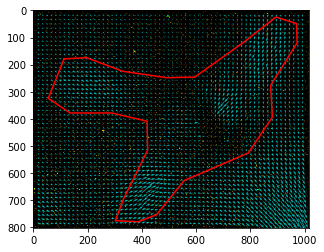

In [18]:
%matplotlib inline
plt.figure()
plt.imshow(cimg,vmin=0,vmax=0.01*cimg.max())
plt.quiver(xgrid,ygrid,xdispRaw,ydispRaw,color='c',units='xy')
plt.plot(cellx,celly,color='r')
plt.show()

## Noise filter

Define noise as standard deviation of displacement of all nodes outside cell boundary. All real displacement needs to be inside of the cell and larger than the 1/2 of the noise level defines.

In [19]:
# Define noise as standard deviation of displacement outside cell boundary
polygon = np.column_stack((cellx,celly))
path = mpltPath.Path(polygon)
inside = path.contains_points(grid,radius=1e-9)
xdrift = np.mean(xdispRaw[~inside])
ydrift = np.mean(ydispRaw[~inside])

xdispd = xdispRaw[inside] - xdrift
ydispd = ydispRaw[inside] - ydrift

dispm = np.sqrt(xdispRaw[~inside]**2 + ydispRaw[~inside]**2)
dispnoise = np.std(dispm)
dispmag = np.sqrt(xdispd**2 + ydispd**2)

realids = np.where(dispmag>0.5*dispnoise)

if np.size(realids)<0.1*np.size(np.where(inside==1)):
    print('Number of nodes with real displacement is too low')

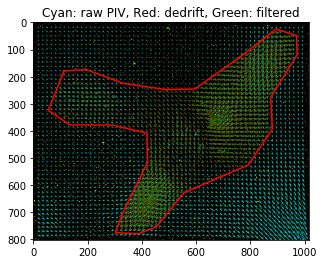

In [21]:
xgridin = xgrid[inside]
ygridin = ygrid[inside]
xgridf = xgridin[realids]
ygridf = ygridin[realids]
gridf = list(zip(xgridf,ygridf))

xdisp = xdispd[realids]
ydisp = ydispd[realids]

fig = plt.figure()
plt.imshow(cimg,vmin=0,vmax=0.01*cimg.max())
plt.quiver(xgrid,ygrid,xdispRaw,ydispRaw,color='c',units='xy')
plt.quiver(xgridin,ygridin,xdispd,ydispd,color='r',units='xy')
plt.quiver(xgridin[realids],ygridin[realids],xdisp,ydisp,color='g',units='xy')
plt.plot(cellx,celly,color='r')
plt.title("Cyan: raw PIV, Red: dedrift, Green: filtered")
plt.show(block=False)

## Bogus 

While sig2noise_val did a good job filtering out bad displacement, it can still miss. Run these cells if you want to manually remove bad displacement nodes by yourself. The program will plot displacement vectors with overlay beads image. If the displacement nodes shown is wrong (empty displacement), simply draw a polygon around those and run the second block to remove them.

In [45]:
## RUN THIS CELL BLOCK AGAIN AFTER RUNNNING NEXT CELL IF YOU STILL NEED TO REMOVE BOGUS IN MORE THAN ONE LOCATION
%matplotlib qt

fig = plt.figure()
plt.imshow(cimg,vmin=0,vmax=0.01*cimg.max())
plt.quiver(xgridin[realids],ygridin[realids],xdisp,ydisp,color='c',units='xy')
plt.plot(cellx,celly,color='r')
plt.title("left click: line segment; right click or double click: close region")
plt.show(block=False)
bogusroi = RoiPoly(color='r',fig=fig,show_fig=False)

In [46]:
## RUN CELL BLOCK ABOVE AGAIN IF YOU STILL NEED TO REMOVE MORE BOGUS
bogusx = np.array(bogusroi.x + [bogusroi.x[0]])
bogusy = np.array(bogusroi.y + [bogusroi.y[0]])
polygon = np.column_stack((bogusx,bogusy))
#polygon = tuple(map(tuple,np.column_stack((bogusx,bogusy)))) 
path = mpltPath.Path(polygon)
inside = path.contains_points(gridf,radius=1e-9)
xdisp[inside] = 0
ydisp[inside] = 0
    
plt.figure()
plt.imshow(cimg,vmin=0,vmax=0.01*cimg.max())
plt.quiver(xgrid,ygrid,uf,vf,color='r',units='xy')
plt.quiver(xgridf,ygridf,xdisp,ydisp,color='c',units='xy')
plt.plot(cellx,celly,color='r')
plt.show(block=False)

## SAVING BLOCK

In [ ]:
np.savez('testcell',
        xgrid=xgrid,
        ygrid=ygrid,
        xdisp=xdisp,
        ydisp=ydisp,
        cellTrace=np.c_[cellx,celly],
        cellimg=cellimg,
        nulfimg=nulfimg,
        loadimg=loadimg,
        cimg=cimg)

## Solving for Force